### This notebook is designed to generate a set of code-vector targets for a trained AutoEncoder model
- This notebook is step 2 of 3 in setting up a model for generating particle decay event images

## Import Libraries

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### Import Files from full path on Meitner Machine

In [2]:
import sys
sys.path.insert(1, '/home/kseuro/Kai/deeplearnphysics/pytorch/particle_generator/')

# Meitner Machine
import ae
import conv_ae
import utils
from dataloader import LArCV_loader

#### Set the GPU to be used for model evaluation
- On Meitner, GPU 1 is the best option

In [3]:
device = torch.device(1)

#### Set the root path of the AutoEncoder Experiments Folder

In [4]:
exp_root = "/media/hdd1/kai/particle_generator/experiments/"

#### Select the model class and append to the experiment root

In [5]:
model_class = {'mlp': 'mlp_ae/', 'conv':'conv_ae/'}

In [6]:
model_folder = "larcv_ae/" + model_class['conv']

In [7]:
exp_root += model_folder

### Find all the experiments in the exp_root folder

In [8]:
exp_paths = []
for path in os.listdir(exp_root):
    exp_paths.append(os.path.join(exp_root, path))

In [9]:
print("-"*60)
for i in range(len(exp_paths)):
    exp_name = exp_paths[i].split('/')[-1]
    print("\n{}:".format(str(i)), exp_name, '\n')
    print("-"*60)

------------------------------------------------------------

0: conv_ae_128_320 

------------------------------------------------------------

1: conv_ae_64_192 

------------------------------------------------------------

2: conv_ae_265_1632 

------------------------------------------------------------


### Choose the experiment for evaluation

In [10]:
exp_dir = exp_paths[2]

In [11]:
# Create the full path to the experiment
exp_path = os.path.join(exp_root, exp_dir) + "/"
print("Experiment path set as: \n{}".format(exp_path))

Experiment path set as: 
/media/hdd1/kai/particle_generator/experiments/larcv_ae/conv_ae/conv_ae_265_1632/


In [12]:
# Set path from where to load the model weights
weights_dir = "weights/"

### Load the model configuration information from the config.csv

In [13]:
# Load the config csv as a dict
config_csv = exp_path + "config.csv"
config_df = pd.read_csv(config_csv, delimiter = ",")

In [14]:
# Get the model architecture from config df
num_epochs = int(config_df[config_df['Unnamed: 0'].str.contains("epochs")==True]['0'].values.item())
n_layers = int(config_df[config_df['Unnamed: 0'].str.contains("n_layers")==True]['0'].values.item())
l_dim    = int(config_df[config_df['Unnamed: 0'].str.contains("l_dim")==True]['0'].values.item())
depth    = int(config_df[config_df['Unnamed: 0'].str.contains("depth")==True]['0'].values.item())
im_size  = int(config_df[config_df['Unnamed: 0'].str.contains("dataset")==True]['0'].values.item())**2
im_dim   = int(np.sqrt(im_size))

## Setup PyTorch DataLoader

### Set the paths to the test data and reference training set

#### Test Data

In [15]:
test_data = "/media/hdd1/kai/particle_generator/larcv_data/test/larcv_png_{}/".format(im_dim)
num_test_ex = sum( [len(examples) for _, _, examples in os.walk(test_data)] )
print("{} test data will be loaded from: \n{}".format(num_test_ex, test_data))

9600 test data will be loaded from: 
/media/hdd1/kai/particle_generator/larcv_data/test/larcv_png_256/


#### Training Data

In [16]:
train_data = "/media/hdd1/kai/particle_generator/larcv_data/train/larcv_png_{}/".format(im_dim)
num_train_ex = sum( [len(examples) for _, _, examples in os.walk(train_data)] )
print("{} training data will be loaded from: \n{}".format(num_train_ex, train_data))

20003 training data will be loaded from: 
/media/hdd1/kai/particle_generator/larcv_data/train/larcv_png_256/


#### Setup two instances of a dataloader object

In [17]:
loader_kwargs = {'num_workers' : 2, 'batch_size': 1, 'shuffle': True}

In [18]:
transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])])

In [19]:
test_dataset = LArCV_loader(root = test_data,  transforms = transforms)

Image conversion flag is: L
Images will be loaded from subfolder of: /media/hdd1/kai/particle_generator/larcv_data/test/larcv_png_256/


In [20]:
test_loader = DataLoader(test_dataset, **loader_kwargs)

In [21]:
train_dataset   = LArCV_loader(root = train_data, transforms = transforms)

Image conversion flag is: L
Images will be loaded from subfolder of: /media/hdd1/kai/particle_generator/larcv_data/train/larcv_png_256/


In [22]:
train_loader = DataLoader(train_dataset, **loader_kwargs)

### Compute the layer dimensions for the AutoEncoder
- TODO: Need to add function that deals with an AutoEncoder Model trained on MNIST

In [23]:
# Set up AE layer sizes
if 'mlp' in exp_path:    
    base = [256] 

    # Compute encoder sizes
    sizes = lambda: [ (yield 2**i) for i in range(n_layers) ]
    enc_sizes = base * n_layers
    enc_sizes = [a*b for a,b in zip(enc_sizes, [*sizes()])][::-1]

    # Update kwarg dicts
    # Decoder is the reverse of the encoder
    ae_kwargs = {'enc_sizes' : enc_sizes, 'l_dim' : l_dim, 'im_size' : im_size, 'dec_sizes' : enc_sizes[::-1]}
else:
    # Compute the depth of the feature maps, based on the number of
    # specified layers. If depth is not divisibe by 4, warn
    depth   = [depth] * n_layers
    divisor = lambda: [ (yield 2**i) for i in range(n_layers) ]
    depth   = [a//b for a,b in zip(depth, [*divisor()])][::-1]
        
    # Update kwarg dicts
    # Decoder is the reverse of the encoder
    ae_kwargs = {'enc_depth':[1] + depth, 'dec_depth':depth[1:len(depth)][::-1] + [1],'l_dim':l_dim}

In [24]:
print("Model l_dim: {}".format(l_dim))
print("Encoder depth: {}".format(ae_kwargs['enc_depth']))
print("Decoder depth: {}".format(ae_kwargs['dec_depth']))

Model l_dim: 102
Encoder depth: [1, 1, 2, 4, 9, 18, 36]
Decoder depth: [36, 18, 9, 4, 2, 1]


## Load Model from Checkpoint

### Get the list of checkpoint files

In [25]:
checkpoint_path  = exp_path + weights_dir
checkpoint_names = []
for file in os.listdir(checkpoint_path):
    checkpoint_names.append(os.path.join(checkpoint_path, file))

In [26]:
# We wish to save a list of labels for ease of plot labelling later
checkpoint_name_labels = []

In [27]:
print("-"*60)
for i in range(len(checkpoint_names)):
    name = checkpoint_names[i].split('/')[-1]
    checkpoint_name_labels.append(name)
    print("\n{}:".format(str(i)), name, '\n')
    print("-"*60)

------------------------------------------------------------

0: best_conv_ae_ep_650.tar 

------------------------------------------------------------

1: best_conv_ae_ep_600.tar 

------------------------------------------------------------

2: best_conv_ae_ep_999.tar 

------------------------------------------------------------

3: best_conv_ae_ep_700.tar 

------------------------------------------------------------

4: best_conv_ae_ep_850.tar 

------------------------------------------------------------

5: best_conv_ae_ep_900.tar 

------------------------------------------------------------

6: best_conv_ae_ep_950.tar 

------------------------------------------------------------

7: best_conv_ae_ep_750.tar 

------------------------------------------------------------

8: best_conv_ae_ep_800.tar 

------------------------------------------------------------


### Select the checkpoint from which you wish to generate code vector targets

In [28]:
index = 2
current_checkpoint = checkpoint_names[index]
current_checkpoint_label = checkpoint_name_labels[index]

### Load the checkpoint file using PyTorch

In [29]:
# Load the model checkpoint
# Keys: ['state_dict', 'epoch', 'optimizer']
checkpoint = torch.load(current_checkpoint)

### Set up the model on the GPU

In [30]:
# Set up model on GPU
if 'mlp' in exp_path:
    model = ae.AutoEncoder(**ae_kwargs).to(device)
else:
    model = conv_ae.ConvAutoEncoder(**ae_kwargs).to(device)

### Load the model's state dictionary

In [31]:
model.load_state_dict(checkpoint['state_dict'], strict=False)

<All keys matched successfully>

### Put model in evaluation mode

In [32]:
model.eval()

ConvAutoEncoder(
  (encoder): ConvEncoder(
    (conv_blocks): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (2): Sequential(
        (0): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (3): Sequential(
        (0): Conv2d(4, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

## Generate a set of code vector targets

### If evaluating convolutional model, get the size of the code tensor using a random torch tensor

In [33]:
if 'conv' in exp_path:
    x = torch.randn(1, 1, im_dim, im_dim).to(device)
    x = model.encoder(x)
    code_dim = (x.shape[1], x.shape[2], x.shape[3])
    print("Code tensor volume is: [{} x {} x {}] = {}".format(code_dim[0], 
                                                              code_dim[1], 
                                                              code_dim[2], 
                                                              code_dim[0]*code_dim[1]*code_dim[2]))

Code tensor volume is: [102 x 4 x 4] = 1632


#### Create directory for saving code layer output targets

In [34]:
# Specify the directory where the code vectors should be saved
deploy_dir = "/media/hdd1/kai/particle_generator/code_vectors/"

In [35]:
if 'mlp' in exp_path:
    deploy_dir += "mlp_ae/code_vectors_{}_{}/".format(im_dim, l_dim)
else:
    deploy_dir += "conv_ae/code_vectors_{}_{}/".format(im_dim, code_dim[0]*code_dim[1]*code_dim[2])

In [36]:
# Create the save directory, if it doesn't already exist
os.mkdir(deploy_dir)

FileExistsError: [Errno 17] File exists: '/media/hdd1/kai/particle_generator/code_vectors/conv_ae/code_vectors_256_1632/'

In [37]:
if 'mlp' in exp_path:
    deploy_dir += "code_vectors_{}_{}/".format(im_dim, l_dim)
else:
    deploy_dir += "code_vectors_{}_{}/".format(im_dim, code_dim[0]*code_dim[1]*code_dim[2])

In [38]:
os.mkdir(deploy_dir)

FileExistsError: [Errno 17] File exists: '/media/hdd1/kai/particle_generator/code_vectors/conv_ae/code_vectors_256_1632/code_vectors_256_1632/'

In [39]:
print("Deploy samples will be saved to:\n{}".format(deploy_dir))

Deploy samples will be saved to:
/media/hdd1/kai/particle_generator/code_vectors/conv_ae/code_vectors_256_1632/code_vectors_256_1632/


### Generate deploy targets by looping over the dataloader using only the encoder

In [40]:
# Codes will be a list of numpy arrays of 32-bit floats
codes = []

In [41]:
for idx, image in enumerate(train_loader):

    # Flatten image into a vector, if mlp
    if 'mlp' in exp_path:
        image = image.view(loader_kwargs['batch_size'], -1).to(device)
    else:
        image = image.to(device)
    
    # Get the output of just the encoder
    code = model.encoder(image)
    
    # If using conv model -- flatten tensor
    if 'conv' in exp_path:
        code = code.view(loader_kwargs['batch_size'], -1).to(device)

    # Save the output tensor to a list
    codes.append(code.detach().cpu().numpy())

In [42]:
print("Generated {} code vectors from {} training images".format(len(codes), len(train_loader)))

Generated 20003 code vectors from 20003 training images


In [43]:
codes[0].size

1632

## Save the list of code vectors to disk
- We then use the built-in np.save function to store the np array as a .npy file
- The numpy array of floats can be read back losslessly using np.load("float_file.npy")
- This process will require the downstream creation of a [custom dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [44]:
for idx, arr in enumerate(codes):
    file_name = deploy_dir + "target_{}.npy".format(idx)
    np.save(file_name, arr)

##### Check that saving actually occured

In [45]:
num_vecs = sum( [len(examples) for _, _, examples in os.walk(deploy_dir)] )

In [46]:
if num_vecs == len(codes):
    print("Saved {} code vectors to \n{}".format(num_vecs, deploy_dir))
else:
    print("Something went wrong...")

Saved 20003 code vectors to 
/media/hdd1/kai/particle_generator/code_vectors/conv_ae/code_vectors_256_1632/code_vectors_256_1632/


## Get a sample of test images from the AutoEncoder Model

##### Make a folder inside of the experiment directory for saving test samples

In [47]:
test_sample_path = exp_path + "test_samples/"

In [48]:
print("Test samples will be saved to {}".format(test_sample_path))

Test samples will be saved to /media/hdd1/kai/particle_generator/experiments/larcv_ae/conv_ae/conv_ae_265_1632/test_samples/


In [49]:
os.mkdir(test_sample_path)

In [65]:
test_ims = []; samples = []; limit = 16

In [66]:
for idx, image in enumerate(test_loader):
    
    # Flatten image into a vector
    if 'mlp' in exp_path:
        image = image.view(loader_kwargs['batch_size'], -1).to(device)
    else:
        image = image.to(device)
    
    # Get sample from model
    sample = model(image)
    
    # Concatenate the two images along the channel dimension and append to list
    # For later plotting with MatPlotLib below this cell
    test_ims.append(image.view(-1, im_dim, im_dim).detach().cpu().numpy())
    samples.append(sample.view(-1, im_dim, im_dim).detach().cpu().numpy())
    
    if idx+1 == limit:
        break

In [67]:
# Compute the plot title
if 'mlp' in exp_path:
    title = "MLP AutoEncoder Test Set Reconstruction Samples"
else:
    title = "Convolutional AutoEncoder Test Set Reconstruction Samples"

In [68]:
# Compute the experiment label
if 'mlp' in exp_path:
    label = "{}x{} Dataset | {} Dimensional Code Vector".format(im_dim, im_dim, l_dim)
else:
    label = "{}x{} Dataset | {}x{}x{} Dimensional Code Volume".format(im_dim, im_dim, code_dim[0], 
                                                                                      code_dim[1], 
                                                                                      code_dim[2])

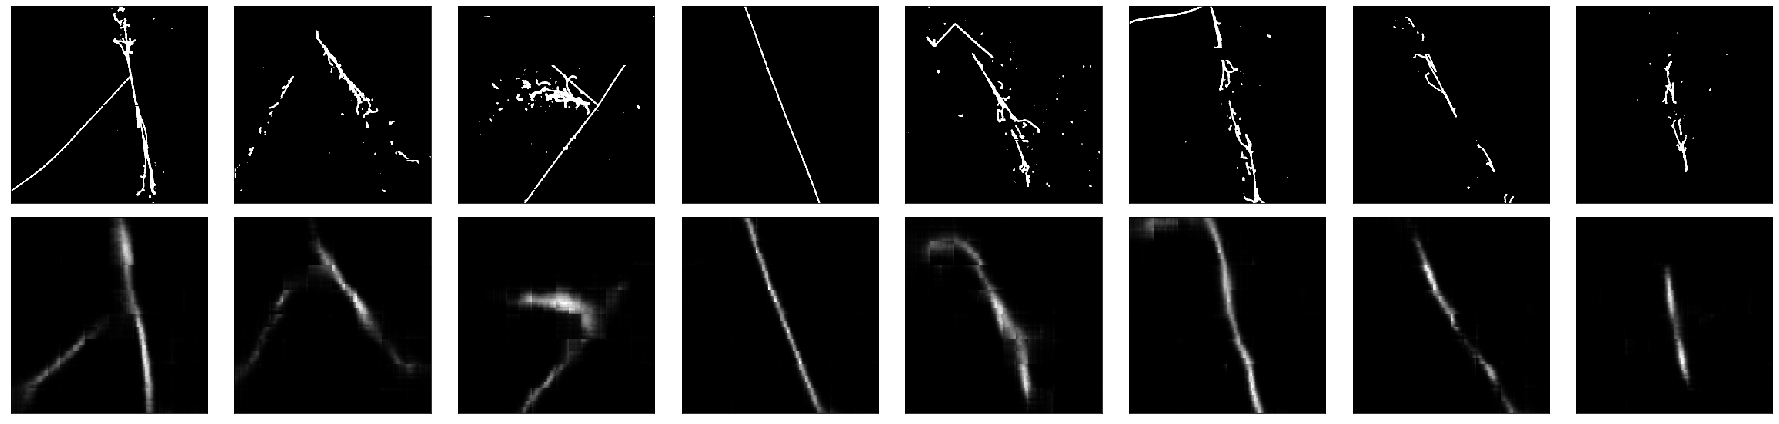

In [69]:
%matplotlib inline
# Setup figure
fig, axes = plt.subplots(nrows = 2, ncols = limit//2, sharex=True, sharey=True, figsize=(25,6))

# plt.suptitle(title)
# plt.title(label)

# Set title
if 'mlp' in exp_path:
    m_label = 'AE'
else:
    m_label = 'Conv_AE'

# title = "{} model test samples using {}x{} dataset".format(m_label, im_dim, im_dim)
# fig.suptitle(title, color="white")

# Generate plot
for images, row in zip([test_ims, samples], axes):
    for img, ax in zip(images, row):
        img = np.reshape(img, (im_dim, im_dim))
        ax.imshow(img, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.tick_params(axis='x', colors='#443941')
        ax.tick_params(axis='y', colors='#443941')

fig.tight_layout()

# Save figure
save_file = "conv_ae_{}_{}.png".format(im_dim, code_dim[0]*code_dim[1]*code_dim[2])
plt.savefig(save_file, dpi=300)